In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [11]:
# Load the dataset
column_names = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", 
    "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"
]
data = pd.read_csv("C:/Users/USER/Downloads/magic04.data", header=None, names=column_names)

# Convert class labels from 'g'/'h' to 1/0
data['class'] = data['class'].map({'g': 1, 'h': 0})  # g = gamma = 1, h = hadron = 0
print(data.head())

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1  


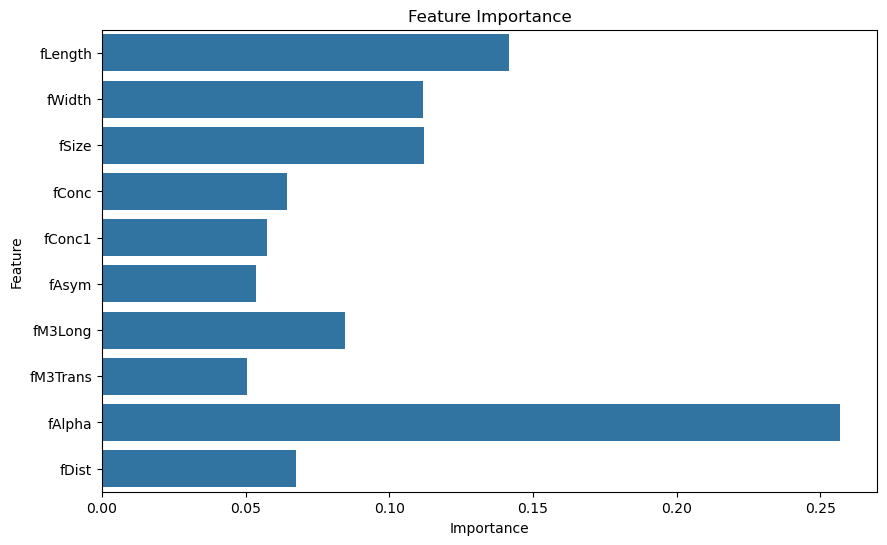

In [12]:
# Explains which variables have the greatest impact on the data.
importances = best_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

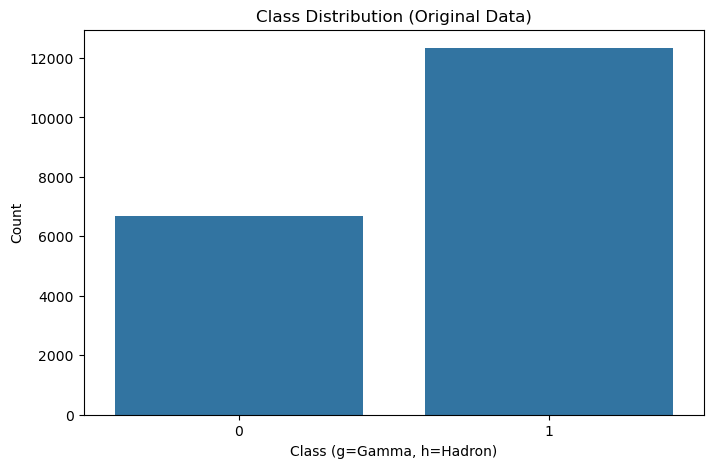

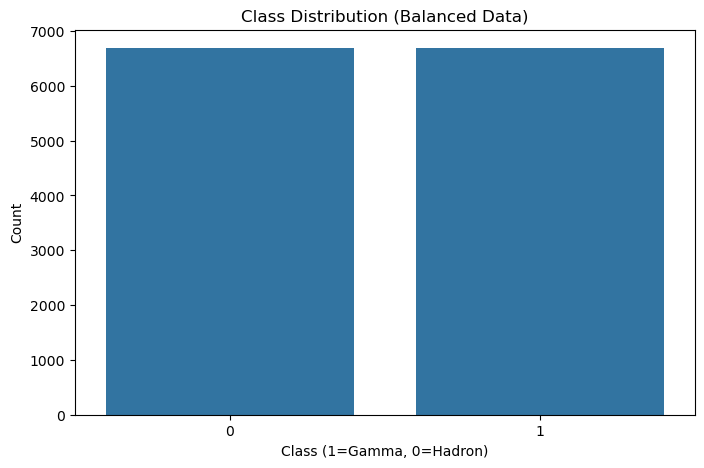

In [13]:

# Distribution of categories in the original data
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=data)
plt.title('Class Distribution (Original Data)')
plt.xlabel('Class (g=Gamma, h=Hadron)')
plt.ylabel('Count')
plt.show()

# Aftar Undersampling
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df_balanced)
plt.title('Class Distribution (Balanced Data)')
plt.xlabel('Class (1=Gamma, 0=Hadron)')
plt.ylabel('Count')
plt.show()

In [14]:
# Separate gamma and hadron rows
gammas = data[data['class'] == 1]
hadrons = data[data['class'] == 0]

# Balance the dataset by randomly sampling the gamma class to match hadron class size
gammas_balanced = gammas.sample(len(hadrons), random_state=42)

# Concatenate the balanced gamma events with the hadron events
df_balanced = pd.concat([gammas_balanced, hadrons])

# Shuffle the dataset to ensure randomness
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the distribution of classes in the balanced dataset
print(df_balanced['class'].value_counts())                                                                                                                                                   #tranforming the class gamma and hadrons to numeric values 0 and 1
label_encoder = LabelEncoder()
df_balanced['class'] = label_encoder.fit_transform(df_balanced['class'])  # 'g'=1, 'h'=0

# Separate features and labels
X = df_balanced.drop('class', axis=1)
y = df_balanced['class']

# Split data into 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

class
0    6688
1    6688
Name: count, dtype: int64


In [15]:
# Define the model and tune 'n_estimators' using GridSearchCV
# n_estimators:n.o.trees in R.F, Increase in the number of trees led to a more accurate model? Usually yes,But it can be expensive sometimes.
param_grid = {'n_estimators': [50, 100, 150, 200]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
#The model is not trained and tested on the entire dataset at once.
#Instead, it uses cross-validation (cv=5), which means it splits the dataset into 5 parts, trains on 4 parts, tests on the 5th part,
#and repeats this process 5 times for each number of trees (n_estimators).

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [16]:
# Train the best model on the full training data
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


Best n_estimators: 200


,precision,recall,f1-score,support
0,0.882632,0.835575,0.858459,2007.000000
1,0.843824,0.888833,0.865744,2006.000000
accuracy,0.862198,0.862198,0.862198,0.862198
macro avg,0.863228,0.862204,0.862102,4013.000000
weighted avg,0.863233,0.862198,0.862101,4013.000000


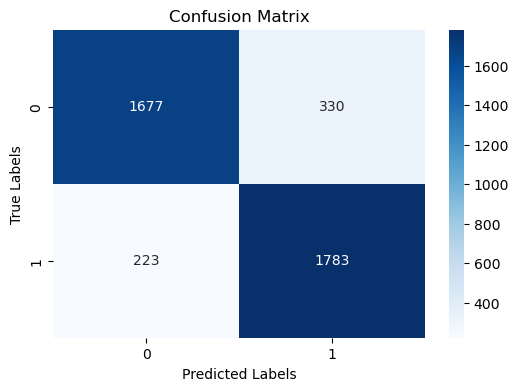

In [17]:
print("Best n_estimators:", grid_search.best_params_['n_estimators'])
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



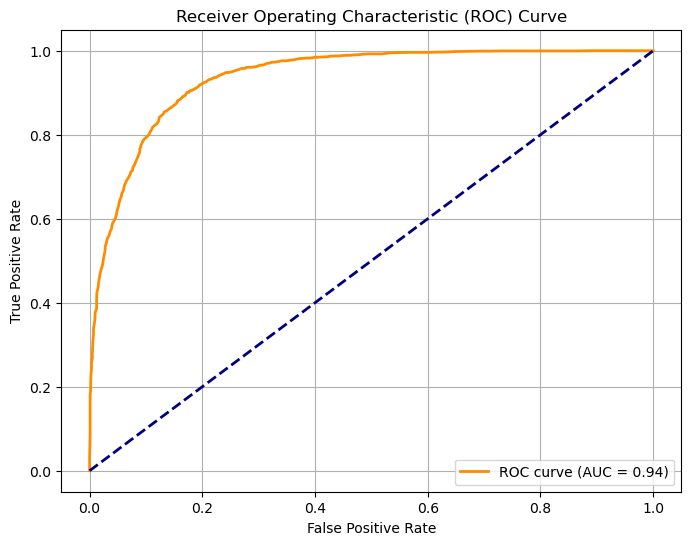

In [20]:
# Shows the model's performance in distinguishing between the two classes (Gamma and Hadron) via the AUC (Area Under Curve) metric.
#An AUC close to 0.5 means that the model distinguishes between Gamma and Hadron randomly.
from sklearn.metrics import roc_curve, auc

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # احتمالية الفئة 1 (Gamma)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# We use these metrics (Precision, Recall, F1-Score, Accuracy, and Confusion Matrix) because they help us evaluate the model's performance accurately.
# Each metric provides specific information about how the model behaves when handling the data.
#--------------------------------------------------------------------------------------------------------------------------------------------------------
# Precision: The proportion of positive predictions that are actually correct.
# Formula: Precision = TP / (TP + FP)
# TP = True Positives (correctly predicted positive samples)
# FP = False Positives (incorrectly predicted as positive)

# Recall: The proportion of actual positive instances that are correctly identified by the model.
# Formula: Recall = TP / (TP + FN)
# TP = True Positives (correctly predicted positive samples)
# FN = False Negatives (actual positives predicted as negatives)

# F1-Score: The harmonic mean of Precision and Recall, providing a balance between the two.
# Formula: F1 = 2 * (Precision * Recall) / (Precision + Recall)

# Accuracy: The proportion of all correct predictions (both true positives and true negatives).
# Formula: Accuracy = (TP + TN) / (TP + TN + FP + FN)
# TP = True Positives
# TN = True Negatives (correctly predicted negatives)
# FP = False Positives
# FN = False Negatives

# Confusion Matrix: A table used to describe the performance of a classification algorithm.
# It shows True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
# Example:
# [[TN, FP],
#  [FN, TP]]

# Support: N.O.SAMPLES

*REPORT*

Precision:
Class 0: 0.88 precision means that when the model predicted class 0, it was correct 88% of the time.

Class 1: 0.84 precision means that when the model predicted class 1, it was correct 84% of the time.

Recall:
Class 0: 0.84 recall means that 84% of the actual instances of class 0 were correctly identified by the model.

Class 1: 0.89 recall means that 89% of the actual instances of class 1 were correctly identified by the model.

F1-Score:
Class 0: 0.86 F1-Score combines both precision and recall for class 0. It means there's a good balance between precision and recall for this class.

Class 1: 0.87 F1-Score shows a similar balance for class 1, slightly higher than for class 0.

Support:
Class 0: 2007 instances belong to class 0 in the dataset.

Class 1: 2006 instances belong to class 1 in the dataset.

Accuracy:
0.86 accuracy means that the model correctly predicted the class for 86% of all instances.

Macro Average:
This is the average performance across all classes, treating each class equally:

Precision: 0.86

Recall: 0.86

F1-Score: 0.86

Weighted Average:
This is the average performance across all classes, weighted by the number of instances (support) in each class:

Precision: 0.86

Recall: 0.86

F1-Score: 0.86

*Summary*
The Random Forest classifier achieved an overall accuracy of 86.2%. With n_estimators tuned to 200, the model showed a good balance between precision (84.3%) and recall (88.8%) for detecting gamma particles.

The classifier performs slightly better in detecting gamma events (recall = 88.8%) compared to hadron events (recall = 84%), which may be beneficial depending on the scientific objective.

Balanced Performance: The model performs quite well with both classes, with a slight advantage in recall for class 1.

Balanced F1-Scores: The F1-Scores are very close, indicating that the model is well-balanced in handling both precision and recall.

*So we can say*the data demonstrates that using physical properties, we can distinguish very well between gamma and hadron signals. Models like Random Forest can learn the relationship between the properties and classify with high accuracy, especially after we balance the data and perform parameter tuning.